# Imbalance Dataset Problem
One of the most common difference between real world data and "fake data" is most of the datasets in real world are 
highly imbalanced. In this notebook, we will learn some of the techniques 

## Sampling

1. Random Undersampling
2. Random Oversampling
3. SMOTE

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Balance Scale Dataset
Let's the load the balance scale dataset taken from UCI as source

Target variable:

The target variable has 3 classes.

R for right-heavy, i.e. when var3 * var4 > var1 * var2
L for left-heavy, i.e. when var3 * var4 < var1 * var2
B for balanced, i.e. when var3 * var4 = var1 * var2

In [83]:
##load data
bs_data = pd.read_csv("data/balance-scale.data")

We can also open the webpage to know more about this dataset

In [84]:
from IPython.display import IFrame
IFrame('http://archive.ics.uci.edu/ml/datasets/balance+scale', width=1200, height=600)

## Explore the dataset
The data is now been loaded to a pandas dataframe, let's try to understand the data a bit more before starting with undersampling

In [85]:
##Check the dataset
bs_data.head()

,B,1,1.1,1.2,1.3
0,R,1,1,1,2
1,R,1,1,1,3
2,R,1,1,1,4
3,R,1,1,1,5
4,R,1,1,2,1


Let's now rename the columns to more sensible ones. We can rename the column names as "balance", "leftWeight", 
"leftDistance", "rightWeight" and "rightDistance"

In [86]:
##Rename columns
bs_data.columns = ["label", "leftWeight", "leftDistance", "rightWeight", "rightDistance"]

As we have learned in our previous notebooks, to get more information about variables we can use df.describe()

In [87]:
bs_data.describe()

,leftWeight,leftDistance,rightWeight,rightDistance
count,624.000000,624.000000,624.000000,624.000000
mean,3.003205,3.003205,3.003205,3.003205
std,1.414210,1.414210,1.414210,1.414210
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [88]:
### Check distibution of label
target_column = 'label'
bs_data[target_column].value_counts()

L    288
R    288
B     48
Name: label, dtype: int64

## Transform into binary classification problem
For this tutorial, let's turn this into a binary classification problem. 
Label:1 -- Implies balanced scale
Label:0 -- Implies imbalanced scale

In [89]:
bs_data['label'] = [1 if b=='B' else 0 for b in bs_data.label]
bs_data[target_column].value_counts()

0    576
1     48
Name: label, dtype: int64

In [90]:
##Quick Null Value Analysis
bs_data.isnull().sum().max()

0

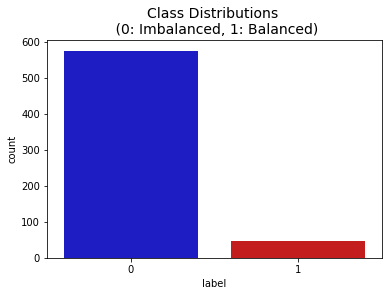

In [91]:
import seaborn as sns
colors = ["#0101DF", "#DF0101"]

sns.countplot('label', data=bs_data, palette=colors)
plt.title('Class Distributions \n (0: Imbalanced, 1: Balanced)', fontsize=14)
plt.show()

In [92]:
## Percentage of Balanced and Imbalanced data
print('Imbalance Class', round(float(bs_data['label'].value_counts()[0])/len(bs_data) * 100,2), '% of the dataset')
print('Balance Class', round(float(bs_data['label'].value_counts()[1])/len(bs_data) * 100,2), '% of the dataset')

Imbalance Class 92.31 % of the dataset
Balance Class 7.69 % of the dataset


# Train a model with imbalanced data
Let's train a simple logistic regression model with this data as input and understand the importance of treating imbalanced data differently

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [94]:
# Separate input features (X) and target variable (y)
y = bs_data.label
X = bs_data.drop('label', axis=1)
 
# Train model
clf_0 = LogisticRegression().fit(X, y)
 
# Predict on training set
y_pred = clf_0.predict(X)

/Users/s2917623/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Let's check the accuracy score for this model.. 

In [95]:
print(accuracy_score(y_pred, y) )

0.9230769230769231


How about printing the Confusion Matrix?

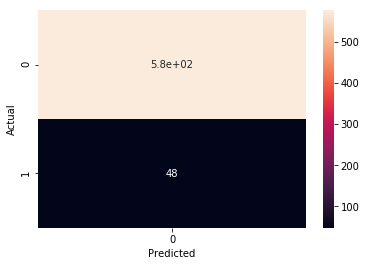

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)

Let's get the classification report to get more clearer insights on the results

In [97]:
from sklearn.metrics import classification_report
target_names = ['Imbalanced', 'Balanced']
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Imbalanced       0.92      1.00      0.96       576
    Balanced       0.00      0.00      0.00        48

    accuracy                           0.92       624
   macro avg       0.46      0.50      0.48       624
weighted avg       0.85      0.92      0.89       624



/Users/s2917623/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/s2917623/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/s2917623/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Sampling Treatment
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).
<img src="images/resampling.png">

## 1. Upsample Minority Class
Upsampling can be done in various ways, one of the ways is to randomly duplicate the minority class 

Before randomly upsampling, let's not forget to take out the test data separately! We would want our test data to be as close to the real data as possible.

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# Separate input features and target
y = bs_data.label
X = bs_data.drop('label', axis=1)

##Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In order to resample, we need to separate the minority and majority class

In [99]:
# # concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
df_majority = X[X.label==0]
df_minority = X[X.label==1]

# upsample minority
upsampled_minority = resample(df_minority,
                          n_samples=len(df_majority), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled_data = pd.concat([df_majority, upsampled_minority])

# check new class counts
upsampled_data.label.value_counts()

1    433
0    433
Name: label, dtype: int64

Check class distribution after upsampling:

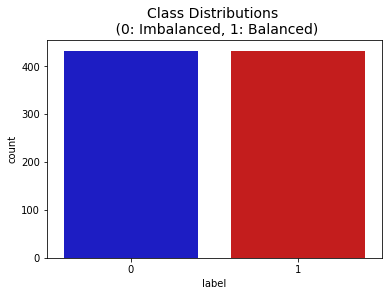

In [100]:
import seaborn as sns
colors = ["#0101DF", "#DF0101"]

sns.countplot('label', data=upsampled_data, palette=colors)
plt.title('Class Distributions \n (0: Imbalanced, 1: Balanced)', fontsize=14)
plt.show()

Train a simple logistic regression model with upsampled data

In [101]:
# trying logistic regression again with the balanced dataset
y_train = upsampled_data.label
X_train = upsampled_data.drop('label', axis=1)

upsampled = LogisticRegression().fit(X_train, y_train)

upsampled_pred_train = upsampled.predict(X_train)
upsampled_pred_test = upsampled.predict(X_test)

print(classification_report(y_train, upsampled_pred_train, target_names=target_names))
print(classification_report(y_test, upsampled_pred_test, target_names=target_names))

              precision    recall  f1-score   support

  Imbalanced       0.51      0.53      0.52       433
    Balanced       0.51      0.48      0.50       433

    accuracy                           0.51       866
   macro avg       0.51      0.51      0.51       866
weighted avg       0.51      0.51      0.51       866

              precision    recall  f1-score   support

  Imbalanced       0.90      0.52      0.66       143
    Balanced       0.07      0.38      0.12        13

    accuracy                           0.51       156
   macro avg       0.49      0.45      0.39       156
weighted avg       0.83      0.51      0.62       156



/Users/s2917623/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 2. Random Undersampling
Let's try to reduce the imbalnce by reducing the number of majority classes

In [102]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
downsampled_majority = resample(df_majority,
                                replace = False, # sample without replacement
                                n_samples = len(df_minority), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled_data = pd.concat([downsampled_majority, df_minority])

# checking counts
downsampled_data.label.value_counts()

1    35
0    35
Name: label, dtype: int64

Let's check the class distribution after downsampling:

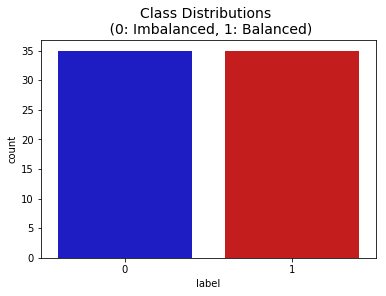

In [103]:
import seaborn as sns
colors = ["#0101DF", "#DF0101"]

sns.countplot('label', data=downsampled_data, palette=colors)
plt.title('Class Distributions \n (0: Imbalanced, 1: Balanced)', fontsize=14)
plt.show()

In [104]:
# trying logistic regression again with the undersampled dataset
y_train = downsampled_data.label
X_train = downsampled_data.drop('label', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred_train = undersampled.predict(X_train)
undersampled_pred_test = undersampled.predict(X_test)

print(classification_report(y_train, undersampled_pred_train, target_names=target_names))
print(classification_report(y_test, undersampled_pred_test, target_names=target_names))

              precision    recall  f1-score   support

  Imbalanced       0.56      0.54      0.55        35
    Balanced       0.56      0.57      0.56        35

    accuracy                           0.56        70
   macro avg       0.56      0.56      0.56        70
weighted avg       0.56      0.56      0.56        70

              precision    recall  f1-score   support

  Imbalanced       0.91      0.42      0.57       143
    Balanced       0.08      0.54      0.14        13

    accuracy                           0.43       156
   macro avg       0.49      0.48      0.36       156
weighted avg       0.84      0.43      0.54       156



Generating Synthetic Samples (SMOTE):

In [114]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = bs_data.label
X = bs_data.drop('label', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27, ratio=0.7)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [115]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred_train = smote.predict(X_train)
smote_pred_test = smote.predict(X_test)

print(classification_report(y_train, smote_pred_train, target_names=target_names))
print(classification_report(y_test, smote_pred_test, target_names=target_names))

              precision    recall  f1-score   support

  Imbalanced       0.66      0.87      0.75       433
    Balanced       0.65      0.36      0.46       303

    accuracy                           0.66       736
   macro avg       0.65      0.61      0.60       736
weighted avg       0.65      0.66      0.63       736

              precision    recall  f1-score   support

  Imbalanced       0.92      0.86      0.89       143
    Balanced       0.13      0.23      0.17        13

    accuracy                           0.81       156
   macro avg       0.53      0.55      0.53       156
weighted avg       0.86      0.81      0.83       156

